Lendo arquivo: df_2020_limpo.csv...
Dados preparados. Total de features processadas: 20
Calculando inércia para diferentes K...


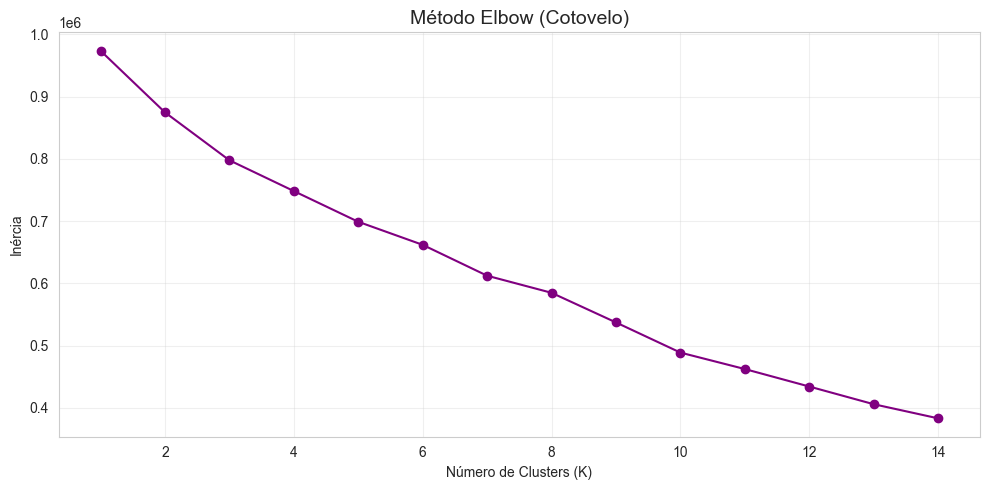


Rodando K-Means com K=5...

--- PERFIS DOS CLUSTERS (Resumo) ---
 CLUSTER  idade     ano  mes_obito      sexo raca_cor estado_civil         esc  QTD_CASOS  PORCENTAGEM
       0  68.32 2021.58       6.58 masculino   Branca        Viúvo  4 a 7 anos       1667         3.42
       1  34.73 2021.62       6.59 masculino    Parda     Solteiro 8 a 11 anos      22001        45.18
       2  51.90 2021.59       6.56 masculino   Branca       Casado 8 a 11 anos      14411        29.60
       3  25.51 2021.63       6.23 masculino Indígena     Solteiro 8 a 11 anos        491         1.01
       4  38.45 2021.61       6.55  feminino   Branca     Solteiro 8 a 11 anos      10123        20.79


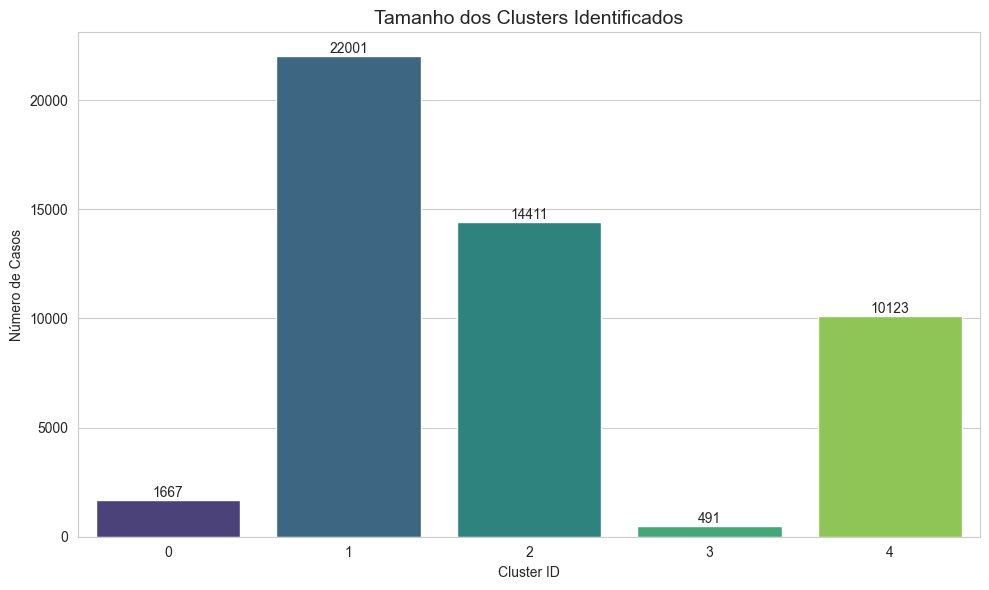


Processo finalizado com sucesso.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings

# Configurações iniciais
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

def carregar_e_limpar_dados(filepath):
    """Carrega o CSV e realiza o pré-processamento inicial."""
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        # Tenta o nome alternativo caso o usuário rode localmente com outro nome
        df = pd.read_csv("df_2020_limpo.csv")
        
    df.columns = df.columns.str.lower()
    
    # Renomeando colunas para facilitar leitura
    mapa_colunas = {
        'racacor': 'raca_cor', 
        'estciv': 'estado_civil', 
        'mes_obito': 'mes_obito'
    }
    df = df.rename(columns=mapa_colunas)
    
    return df

def tratar_valores_nulos(df, cols_num, cols_cat):
    """Preenche valores nulos com Média (numéricos) e Moda (categóricos)."""
    df_clean = df.copy()
    
    for col in cols_cat:
        if col in df_clean.columns:
            moda = df_clean[col].mode()[0]
            df_clean[col] = df_clean[col].fillna(moda)
            
    for col in cols_num:
        if col in df_clean.columns:
            media = df_clean[col].mean()
            df_clean[col] = df_clean[col].fillna(media)
            
    return df_clean

def preparar_features(df, cols_num, cols_cat):
    """Aplica One-Hot Encoding e Padronização (StandardScaler)."""
    # 1. One-Hot Encoding para categóricas
    df_dummies = pd.get_dummies(df, columns=cols_cat, prefix=cols_cat)
    
    # Identificar todas as colunas geradas (numéricas originais + dummies)
    colunas_finais = cols_num + [c for c in df_dummies.columns if c not in df.columns and c not in cols_num]
    
    # Filtrar apenas as colunas que usaremos no modelo
    features_df = df_dummies[colunas_finais]
    
    # 2. Padronização (StandardScaler)
    # Importante: O K-Means é sensível à escala (Idade 60 vs Mês 12), então tudo deve estar na mesma escala.
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)
    
    return features_scaled, features_df.columns

def calcular_elbow(features_scaled, max_k=15):
    """Gera o gráfico do método Elbow para ajudar na decisão do K."""
    inertia_values = []
    k_range = range(1, max_k)
    
    print("Calculando inércia para diferentes K...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features_scaled)
        inertia_values.append(kmeans.inertia_)
        
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, inertia_values, marker='o', linestyle='-', color='purple')
    plt.title('Método Elbow (Cotovelo)', fontsize=14)
    plt.xlabel('Número de Clusters (K)')
    plt.ylabel('Inércia')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def executar_kmeans(df, features_scaled, k_escolhido=5):
    """Roda o K-Means final e adiciona os labels ao DataFrame original."""
    kmeans = KMeans(n_clusters=k_escolhido, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_scaled)
    
    df_resultado = df.copy()
    df_resultado['CLUSTER'] = labels
    
    return df_resultado

def gerar_relatorio_perfis(df_resultado, cols_num, cols_cat):
    """Gera um resumo legível dos perfis encontrados."""
    # Média das variáveis numéricas por cluster
    perfil_num = df_resultado.groupby('CLUSTER')[cols_num].mean().reset_index()
    
    # Moda das variáveis categóricas por cluster
    perfil_cat = df_resultado.groupby('CLUSTER')[cols_cat].agg(lambda x: x.mode()[0]).reset_index()
    
    # Unir os dois
    perfil_final = pd.merge(perfil_num, perfil_cat, on='CLUSTER')
    
    # Contagem e porcentagem
    contagem = df_resultado['CLUSTER'].value_counts().reset_index()
    contagem.columns = ['CLUSTER', 'QTD_CASOS']
    contagem['PORCENTAGEM'] = (contagem['QTD_CASOS'] / contagem['QTD_CASOS'].sum()) * 100
    
    perfil_final = pd.merge(perfil_final, contagem, on='CLUSTER')
    
    return perfil_final.sort_values(by='CLUSTER')

def plotar_distribuicao_clusters(perfil_final):
    """Plota o gráfico de barras com o tamanho de cada cluster."""
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='CLUSTER', y='QTD_CASOS', data=perfil_final, palette='viridis')
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom')
        
    plt.title('Tamanho dos Clusters Identificados', fontsize=14)
    plt.ylabel('Número de Casos')
    plt.xlabel('Cluster ID')
    plt.tight_layout()
    plt.show()

# --- Execução Principal ---
if __name__ == "__main__":
    # 1. Definição das colunas de interesse
    feature_cols_num = ['idade', 'ano', 'mes_obito']
    feature_cols_cat = ['sexo', 'raca_cor', 'estado_civil', 'esc']

    # 2. Carregar
    # Substitua pelo nome correto do seu arquivo se necessário
    arquivo = "df_2020_limpo.csv" 
    print(f"Lendo arquivo: {arquivo}...")
    df = carregar_e_limpar_dados(arquivo)

    # 3. Tratar Nulos
    df = tratar_valores_nulos(df, feature_cols_num, feature_cols_cat)

    # 4. Preparar (Encoding + Scaling)
    features_scaled, feature_names = preparar_features(df, feature_cols_num, feature_cols_cat)
    print(f"Dados preparados. Total de features processadas: {features_scaled.shape[1]}")

    # 5. Decidir K (Visualizar Elbow)
    # Dica: Olhe o gráfico gerado e ajuste 'k_final' abaixo conforme onde a curva "dobra"
    calcular_elbow(features_scaled)
    
    k_final = 5 # Defina aqui o K ideal após olhar o gráfico
    print(f"\nRodando K-Means com K={k_final}...")

    # 6. Agrupar
    df_clustered = executar_kmeans(df, features_scaled, k_escolhido=k_final)

    # 7. Relatório e Visualização Final
    perfis = gerar_relatorio_perfis(df_clustered, feature_cols_num, feature_cols_cat)
    
    print("\n--- PERFIS DOS CLUSTERS (Resumo) ---")
    print(perfis.round(2).to_string(index=False))
    
    plotar_distribuicao_clusters(perfis)
    print("\nProcesso finalizado com sucesso.")